# ODEs with JAX

A big benefit of using JAX to write our statistical models is that we
don’t have to use specialised HMC optimised ODE software. As long as an
ODE solving library is generally JAX-compatible, we can use it in our
Bayesian statistical models.

In practice there are two main choices:
[probdiffeq](https://pnkraemer.github.io/probdiffeq/) and
[diffrax](https://docs.kidger.site/diffrax/). Here we’ll focus on
diffrax, as we (Teddy, Nick and Sergi) have more experience with it.

We’ll use diffrax to solve the initial value problem introduced in the
last session, then embed this solution inside a statistical model.

## imports

In [1]:
from functools import partial

import operator
import arviz as az
import diffrax
import numpy as np
import jax

from jax import numpy as jnp
from jax import scipy as jsp
from matplotlib import pyplot as plt

### Specify true parameters

This code specifies the dimensions of our problem.

In [2]:
N_strain = 4
N_tube = 16
N_timepoint = 50
duration = 30
strains = [i + 1 for i in range(N_strain)]
tubes = [i + 1 for i in range(N_tube)]
species = ["biomass", "substrate"]
measurement_times = np.array([4.0, 7.0, 12.0, 15.0, 17.0])
timepoints = jnp.linspace(0.01, duration, N_timepoint)

To generate random numbers with JAX we need to explicitly create some
random key objects.

In [3]:
SEED = 12345
key = jax.random.key(seed=SEED)
rng_key, key = jax.random.split(key)
rng_key_a, rng_key_b, rng_key_c, rng_key_d = jax.random.split(rng_key, 4)

This code defines some true values for the parameters - we will use
these to generate fake data. Note that we avoid putting any constrained
variables in the parameters using some log transformations.

In [4]:
a_mu_max = -1.7
log_t_mu_max = jnp.log(0.2)
a_ks = -1.3
a_mu_max = -1.7
a_gamma = -0.6
tau_mu_max = 0.2
tau_ks = 0.3
tau_gamma = 0.13
target_conc_init = jnp.array([-2.1, 0.2])
target_conc_init_scale = jnp.array([0.1, 0.05])

true_params = {
    "a_mu_max": a_mu_max,
    "a_ks": a_ks,
    "a_gamma": a_gamma,
    "log_tau_mu_max": jnp.log(tau_mu_max),
    "log_tau_ks": jnp.log(tau_ks),
    "log_tau_gamma": jnp.log(tau_gamma),
    "log_conc_init": target_conc_init
    + target_conc_init_scale
    * jax.random.normal(
        key=rng_key_a,
        shape=(N_strain, 2),
    ),
    "log_sigma": jnp.log(jnp.array([0.08, 0.1])),
    "log_mu_max": a_mu_max
    + tau_mu_max * jax.random.normal(rng_key_b, shape=(N_strain,)),
    "log_ks": a_ks + tau_ks * jax.random.normal(rng_key_c, shape=(N_strain,)),
    "log_gamma": a_gamma
    + tau_gamma
    * jax.random.normal(
        rng_key_d,
        shape=(N_strain,),
    ),
}


def get_strain_params(strain_ix, params):
    def slice(leaf):
        return (
            leaf[strain_ix]
            if (hasattr(leaf, "shape") and leaf.ndim > 0 and leaf.shape[0] == N_strain)
            else leaf
        )

    return jax.tree.map(slice, params)

true_params_strain_2 = get_strain_params(2, true_params)
true_params_strain_2

{'a_gamma': -0.6,
 'a_ks': -1.3,
 'a_mu_max': -1.7,
 'log_conc_init': Array([-2.043062,  0.148519], dtype=float32),
 'log_gamma': Array(-0.5753846, dtype=float32),
 'log_ks': Array(-1.4795702, dtype=float32),
 'log_mu_max': Array(-1.9427458, dtype=float32),
 'log_sigma': Array([-2.5257287, -2.3025851], dtype=float32),
 'log_tau_gamma': Array(-2.040221, dtype=float32, weak_type=True),
 'log_tau_ks': Array(-1.2039728, dtype=float32, weak_type=True),
 'log_tau_mu_max': Array(-1.609438, dtype=float32, weak_type=True)}

### Defining the dynamics

To implement our model using diffrax, we need to write down the dynamics
as a Python function with a special signature `t, y, args`, where `t` is
a float representing the time, `y` is a jax array of state variables and
`args` is an arbitrary auxiliary
[PyTree](https://docs.jax.dev/en/latest/pytrees.html), in this case a
dictionary of parameters pertaining to a strain.

In [5]:
def monod_kinetics(t, y, args):
    x, s = y
    mu_max = jnp.exp(args["log_mu_max"])
    ks = jnp.exp(args["log_ks"])
    gamma = jnp.exp(args["log_gamma"])
    mu = (mu_max * s) / (ks + s)
    return jnp.array([mu * x, -gamma * mu * x])

### Solving the initial value problem

The next step is to wrap this function using the diffrax class `ODETerm`

In [6]:
monod_term = diffrax.ODETerm(monod_kinetics)

Now we can choose a solver, stepsize controller and initial sensitivity

In [7]:
solver = diffrax.Kvaerno5()
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
dt0 = 0.001


Now we can make a function for solving our initial value problem

In [8]:
def solve_monod(args, timepoints):
    t0 = 0.0
    tf = timepoints[-1]
    y0 = jnp.exp(args["log_conc_init"])
    saveat = diffrax.SaveAt(ts=timepoints)
    return diffrax.diffeqsolve(
        monod_term,
        solver,
        t0=t0,
        t1=tf,
        dt0=dt0,
        y0=y0,
        saveat=saveat,
        args=args,
        stepsize_controller=stepsize_controller,
    )

solution = solve_monod(args=true_params_strain_2, timepoints=timepoints)

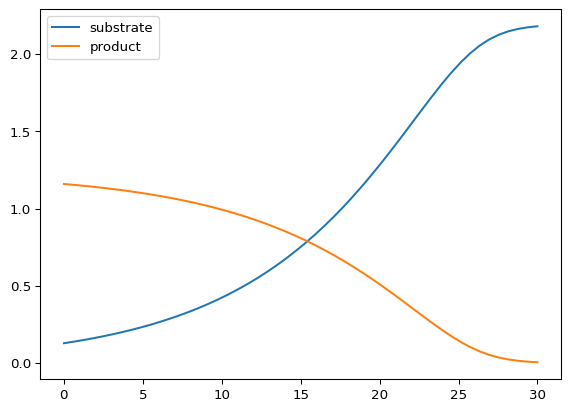

In [9]:
f, ax = plt.subplots()
for yi, label in zip(solution.ys.T, ["substrate", "product"]):
    ax.plot(timepoints, yi, label=label)
ax.legend()

Nice!

## Defining a model

### Joint log density function

The next step is to write a joint log density function that connects
parameters and data with measurables using `solve_monod`. We’ll do this
bit by bit, starting with the prior log density:

In [10]:
def prior_log_density(params, prior):
    loc, scale = prior
    return jax.tree.map(jsp.stats.norm.logpdf, params, loc, scale)

example_prior_loc = jax.tree.map(jnp.array, true_params)
example_prior_scale = jax.tree.map(
    lambda x: jnp.full_like(x, 0.1),
    true_params,
)
example_prior = (example_prior_loc, example_prior_scale)
example_log_prior = prior_log_density(true_params, example_prior)
example_log_prior

{'a_gamma': Array(1.3836465, dtype=float32, weak_type=True),
 'a_ks': Array(1.3836465, dtype=float32, weak_type=True),
 'a_mu_max': Array(1.3836465, dtype=float32, weak_type=True),
 'log_conc_init': Array([[1.3836465, 1.3836465],
        [1.3836465, 1.3836465],
        [1.3836465, 1.3836465],
        [1.3836465, 1.3836465]], dtype=float32),
 'log_gamma': Array([1.3836465, 1.3836465, 1.3836465, 1.3836465], dtype=float32),
 'log_ks': Array([1.3836465, 1.3836465, 1.3836465, 1.3836465], dtype=float32),
 'log_mu_max': Array([1.3836465, 1.3836465, 1.3836465, 1.3836465], dtype=float32),
 'log_sigma': Array([1.3836465, 1.3836465], dtype=float32),
 'log_tau_gamma': Array(1.3836465, dtype=float32, weak_type=True),
 'log_tau_ks': Array(1.3836465, dtype=float32, weak_type=True),
 'log_tau_mu_max': Array(1.3836465, dtype=float32, weak_type=True)}

now the likelihood:

In [11]:
def likelihood_log_density(obs, params, measurement_times):
    n_strain = params["log_mu_max"].shape[0]
    strains = jnp.arange(n_strain)
    yhat = jax.vmap(
        lambda i: solve_monod(get_strain_params(i, params), measurement_times).ys,
    )(strains)
    log_yhat = jnp.log(jnp.maximum(yhat, jnp.full_like(yhat, 1e-9)))
    sigma = jnp.exp(params["log_sigma"])
    log_obs = jnp.log(obs)
    return jsp.stats.norm.logpdf(log_obs, log_yhat, sigma)


def simulate_measurements(key, params, measurement_times):
    n_strain = params["log_mu_max"].shape[0]
    strains = jnp.arange(n_strain)
    yhat = jax.vmap(
        lambda i: solve_monod(get_strain_params(i, params), measurement_times).ys
    )(strains)
    sigma = jnp.exp(params["log_sigma"])
    noise = jax.random.normal(key, shape=yhat.shape) * sigma
    return jnp.exp(jnp.log(yhat) + noise)


sim_key, key = jax.random.split(key)
example_obs = simulate_measurements(sim_key, true_params, measurement_times)
example_obs

Array([[[0.22783391, 0.96208405],
        [0.2802295 , 1.1829902 ],
        [0.6151478 , 0.96014714],
        [0.808359  , 0.8715509 ],
        [1.0103092 , 0.59285116]],

       [[0.23718558, 0.87122196],
        [0.2716521 , 1.252538  ],
        [0.46342003, 0.94091225],
        [0.6423971 , 1.1722577 ],
        [0.78577113, 0.8686925 ]],

       [[0.23523214, 1.3224756 ],
        [0.29459015, 0.84505486],
        [0.48906034, 1.069513  ],
        [0.64119184, 0.58480805],
        [0.7719773 , 0.76687366]],

       [[0.19057587, 1.1378189 ],
        [0.2525575 , 1.0086107 ],
        [0.4153177 , 0.83254826],
        [0.6303718 , 1.1003901 ],
        [0.6436955 , 0.885998  ]]], dtype=float32)

In [12]:
likelihood_log_density(example_obs, true_params, measurement_times)

Array([[[ 0.6803185 ,  0.21532977],
        [ 1.2108381 ,  0.8320693 ],
        [ 1.0624793 ,  1.2488012 ],
        [ 1.6026926 ,  0.5788903 ],
        [ 1.588413  ,  1.0270905 ]],

       [[-0.29656756, -1.6563145 ],
        [ 1.5831385 ,  0.18755579],
        [ 1.6001872 ,  1.3399622 ],
        [ 1.4896955 , -2.7660604 ],
        [ 1.4342949 ,  1.0837686 ]],

       [[ 0.51660633, -0.0654397 ],
        [ 1.5944276 , -1.2969908 ],
        [ 0.9780934 ,  0.43840444],
        [-0.3893932 , -3.9161468 ],
        [-1.3531868 ,  1.035675  ]],

       [[ 1.6066262 ,  1.3783708 ],
        [ 1.5671532 ,  0.90355957],
        [ 1.5661874 , -0.6937643 ],
        [ 0.7906398 ,  0.16633916],
        [ 1.2486979 ,  1.3766443 ]]], dtype=float32)

And finally we can write down a joint log density function

In [13]:
def joint_log_density(params, obs, prior, measurement_times):
    lprior = prior_log_density(params, prior)
    llik = likelihood_log_density(obs, params, measurement_times)
    lprior_sum = jax.tree.reduce(operator.add, jax.tree.map(jnp.sum, lprior))
    llik_sum = jax.tree.reduce(operator.add, jax.tree.map(jnp.sum, llik))
    return lprior_sum + llik_sum


joint_log_density(true_params, example_obs,  example_prior, measurement_times)

Array(60.241196, dtype=float32)

### Posterior

When we have concrete values for observations, prior and measurement
times, we want a new function based on the joint log density, where
these values are fixed. This is an ideal job for the Python standard
library function `partial`. The resulting posterior log density function
has only one argument for parameters.

In [14]:
posterior_log_density = partial(
    joint_log_density,
    obs=example_obs,
    prior=example_prior,
    measurement_times=measurement_times
)
posterior_log_density(true_params)

Array(60.241196, dtype=float32)

## MCMC

Now we can generate posterior samples using adaptive Hamiltonian Monte
Carlo via the library
[blackjax](https://blackjax-devs.github.io/blackjax/).

> **Note**
>
> Multi-chain MCMC with Blackjax is a bit annoying to do manually so I
> made some convenience functions `run_nuts` and `get_idata`. These
> should probably already be installed - if not just run `uv sync` from
> the project root.

In [15]:
from blackjax_utils import run_nuts, get_idata
states, info = run_nuts(
    key,
    jax.jit(posterior_log_density),
    init_params=example_prior_loc,
    n_chain=4,
    n_warmup=200,
    n_sample=200,
    target_acceptance_rate=0.9,
    initial_step_size=0.001,
)

coords = {
    "strain": strains,
    "tube": tubes,
    "species": species,
    "timepoint": timepoints,
}
dims = {
    "log_conc_init": ["strain", "species"],
    "log_gamma": ["strain"],
    "log_ks": ["strain"],
    "log_mu_max": ["strain"],
    "log_sigma": ["species"],
}

idata = get_idata(states, info, coords=coords, dims=dims)
n_divergent = idata.sample_stats["is_divergent"].sum().item()
print(f"Number of divergent transitions: {n_divergent}")
print(az.summary(idata))

Number of divergent transitions: 0
                              mean     sd  hdi_3%  hdi_97%  mcse_mean  \
a_gamma                     -0.601  0.095  -0.771   -0.425      0.002   
a_ks                        -1.303  0.113  -1.509   -1.099      0.003   
a_mu_max                    -1.698  0.100  -1.882   -1.517      0.002   
log_conc_init[1, biomass]   -2.073  0.060  -2.182   -1.955      0.002   
log_conc_init[1, substrate]  0.163  0.045   0.076    0.249      0.001   
log_conc_init[2, biomass]   -1.954  0.057  -2.066   -1.855      0.002   
log_conc_init[2, substrate]  0.179  0.045   0.094    0.260      0.001   
log_conc_init[3, biomass]   -1.968  0.059  -2.073   -1.859      0.002   
log_conc_init[3, substrate]  0.094  0.045   0.013    0.173      0.002   
log_conc_init[4, biomass]   -2.064  0.061  -2.183   -1.948      0.002   
log_conc_init[4, substrate]  0.151  0.043   0.072    0.236      0.001   
log_gamma[1]                -0.553  0.087  -0.712   -0.387      0.003   
log_gamma[2]    

> **Exercise**
>
> How good was our model?
>
> To answer this question, try:
>
> -   for each parameter, compare the true value with the model’s
>     marginal posterior distribution.
> -   plot the timecourses for a sample of parameters and compare with
>     the real timecourse